# Системы обыкновенных дифференциальных уравнений

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import scipy.optimize as op

# VIII.11.4

<img src="VIII.11.4.png" width=900/>

### **Все системы уравнений ВО ВСЕХ ПУНКТАХ будем задавать в виде:**
$$\frac{d\vec{x}}{dt} = f(\vec{x}, t)$$

In [2]:
def F(t : float, x : np.array) -> np.array:
    __x, __y, __z, __u = x
    return np.array([
        __z,
        __u,
        - __x / (__x**2 + __y**2)**(3/2),
        - __y / (__x**2 + __y**2)**(3/2)
    ])

F(0, [0.5, 0, 0, 1.73])

#
# Входные данные: начальные условия, система и др. 
# (используется во всех методах задания VIII.11.4).
#
class Input:
    fn = F
    x_0 = np.array([0.5, 0, 0, 1.73])
    t_0 = 0
    t_max = 20
    
    #
    # Визуализация решения.
    #
    def visualize(t_points, points):
        x, y, z, u = points.transpose()
        fig, [timed, phase] = plt.subplots(1, 2, figsize=(14, 4))
        size = 0.5
        
        timed.scatter(t_points, x, label='x(t)', s=size)
        timed.scatter(t_points, y, label='y(t)', s=size)
        timed.scatter(t_points, z, label='z(t)', s=size)
        timed.scatter(t_points, u, label='u(t)', s=size)
        timed.set_xlabel('t')
        timed.legend()
    
        phase.scatter([0], [0], label='Фокус', s=4*size, color='red')
        phase.scatter(x, y, label='Траектория', s=size)
        phase.set_xlabel('x')
        phase.set_ylabel('y')
        phase.legend()

## Методы Рунге-Кутта **(явные и неявные!)**

Хотелось проверить разные вариации РК-методов. Поэтому сделал универсально (но не оптимально). Для прогонки достаточно загнать таблицу Бутчера.

Таблицы Бутчера брал отсюда:
https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods

In [3]:
class Butcher:
    def __init__(self, A, b, c):
        assert len(A) == len(b) == len(c), 'Arrays lengths mismatch'
        self.A = A
        self.b = b
        self.c = c
    def calculateOrder(self):
        __sum = np.sum(self.b)
        print(f'O1: Sum of b_i = {__sum} == 1 ? {__sum == 1}\n')

        __sum = np.sum(self.b * self.c )
        print(f'O2: Sum of b_i*c_i = {__sum} == 1/2 ? {__sum == 1/2}\n')

        __sum = np.sum(self.b * self.c * self.c)
        print(f'O3: Sum of b_i*c_i^2 = {__sum} == 1/3 ? {__sum == 1/3}')
        __sum = np.sum(self.b * np.matmul(self.A, self.c))
        print(f'O3: Sum of b_i*a_ij*c_j = {__sum} == 1/6 ? {__sum == 1/6}\n')

        __sum = np.sum(self.b * self.c * self.c * self.c)
        print(f'O4: Sum of b_i*c_i^3 = {__sum} == 1/4 ? {__sum == 1/4}')
        __sum = np.sum(self.b * self.c * np.matmul(self.A, self.c))
        print(f'O4: Sum of b_i*c_i*a_ij*c_j = {__sum} == 1/8 ? {__sum == 1/8}')
        __sum = np.sum(self.b * np.matmul(self.A, self.c * self.c))
        print(f'O4: Sum of b_i*a_ij*c_j^2 = {__sum} == 1/12 ? {__sum == 1/12}')
        __sum = np.sum(self.b * np.matmul(self.A, np.matmul(self.A, self.c)))
        print(f'O4: Sum of b_i*a_ij*a_jk*c_k = {__sum} == 1/24 ? {__sum == 1/24}\n')
        
        return 3

#
# Система уравнений Рунге-Кутта для определения k_i.
# (см. https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)
#
# На вход ожидаем таблицу Бутчера и предыдущую итерацию.
# Возвращаем систему уравнений на k_i:
#
# k_i - f(t_n + c_i * h, x_n + h * SUM_j^s(a_ij * k_j)) = 0
#
class RK_System:
    def __init__(self, butcher_tab, fn, t_n, x_n, h_step):
        
        self.A = butcher_tab.A
        self.b = butcher_tab.b
        self.c = butcher_tab.c
        self.fn = fn
        self.h = h_step
        self.x_n = x_n
        self.t_n = t_n
        self.steps = len(c)

    def __call__(self, k_flatten):
        __k = k_flatten.reshape((self.steps, len(self.x_n)))
        __res = np.zeros(__k.shape)
        for i in range(self.steps):
            __res[i] = __k[i] - self.fn(self.t_n + self.c[i] * self.h, self.x_n + self.h * self.A[i].dot(__k))
        return __res.flatten()

#
# Великий решатель ОДУ методом Рунге-Кутта.
#
def RK_Solve(butcher_tab, fn, t_0, x_0, h_step, n_iters): 
    
    __x_points = [x_0]
    __t_points = [t_0]

    __t_n = t_0
    __x_n = x_0

    __k_0 = np.zeros((len(c), len(__x_n)))
    for __i in range(n_iters):
        
        __rk_system = RK_System(butcher_tab, fn, __t_n, __x_n, h_step)
        __k = op.fsolve(__rk_system, __k_0).reshape(__k_0.shape)

        __x_n = __x_n + h_step * np.matmul(b, __k)
        __t_n = __t_n + h_step

        __x_points.append(__x_n)
        __t_points.append(__t_n)

    return np.array(__t_points), np.array(__x_points)
    

In [30]:
# Порядок аппроксимации
A = np.array([
    [  1,  0],
    [-1,  1],
])

b = np.array([1/2, 1/2])
c = np.array([  1, 0])
euler_butcher = Butcher(A, b, c)
euler_butcher.calculateOrder()



O1: Sum of b_i = 1.0 == 1 ? True

O2: Sum of b_i*c_i = 0.5 == 1/2 ? True

O3: Sum of b_i*c_i^2 = 0.5 == 1/3 ? False
O3: Sum of b_i*a_ij*c_j = 0.0 == 1/6 ? False

O4: Sum of b_i*c_i^3 = 0.5 == 1/4 ? False
O4: Sum of b_i*c_i*a_ij*c_j = 0.5 == 1/8 ? False
O4: Sum of b_i*a_ij*c_j^2 = 0.0 == 1/12 ? False
O4: Sum of b_i*a_ij*a_jk*c_k = -0.5 == 1/24 ? False



3

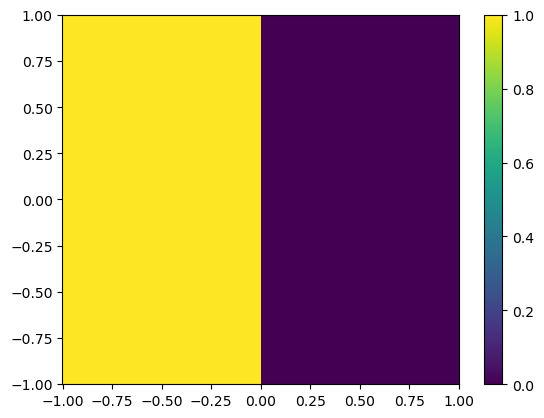

In [34]:
#from sympy import *
#x = symbols('x')
#p1 = plot_implicit(And(Re(x) > 0))


x = np.linspace(-1, 1, 500)
y = np.linspace(-1, 1, 500)

# Функция устойчивости R(z)
R = lambda z: (1 + z/2) / (1 - z/2) # 1 + 1/(2*(1-z)**2) * (2 - 3*z)

xx, yy = np.meshgrid(x, y)
zz = np.abs(R(xx + 1j * yy)) < 1

# Область устойчивости
plt.pcolormesh(x, y, zz)
plt.colorbar()

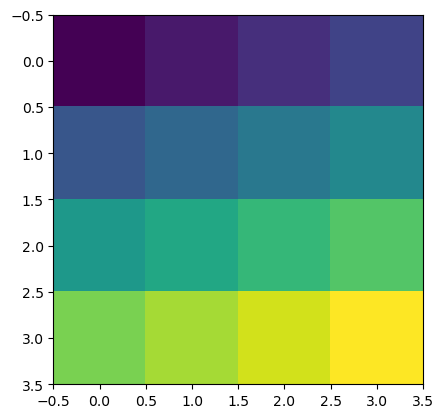

In [70]:
H = np.array([[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [13, 14, 15, 16]])

plt.imshow(H, interpolation='none')
plt.show()

### Метод Эйлера

<img src="Euler-RK.png" width=1100/>

Метод Эйлера сильно уступает остальным методам по качеству решения. Эллипс раскрутился...

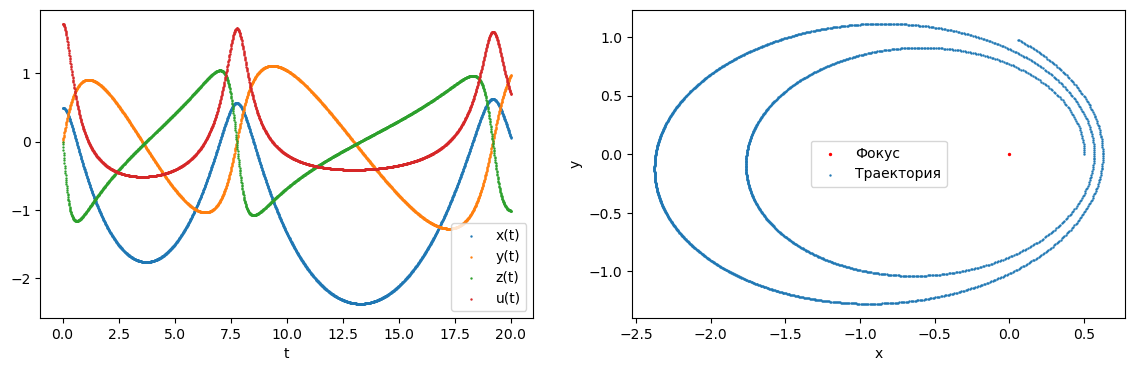

In [165]:
A = np.array([
    [0],
])

b = np.array([1])
c = np.array([0])

euler_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(euler_butcher, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

### Явный метод Рунге-Кутта третьего порядка

<img src="Kutta3rd-RK.png" width=900/>

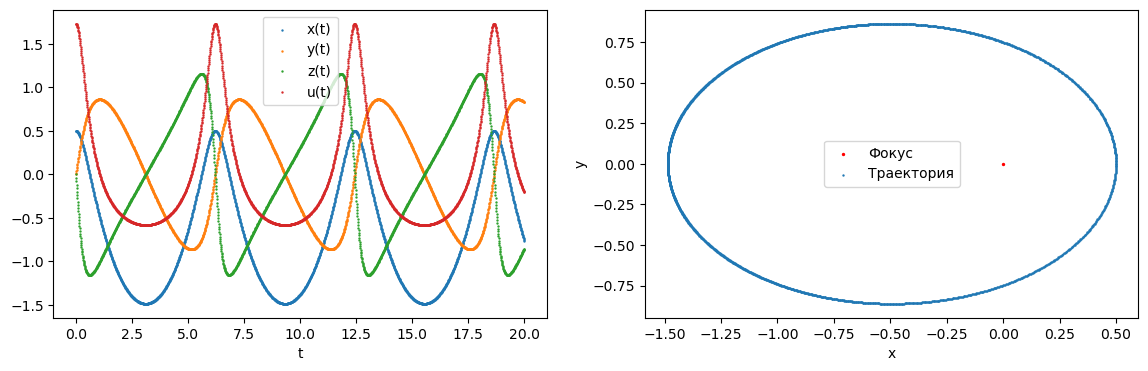

In [166]:

A = np.array([
    [  0,  0, 0],
    [1/2,  0, 0],
    [ -1,  2, 0],
])

b = np.array([1/6, 2/3, 1/6])
c = np.array([  0, 1/2,   1])

kutta_3rd_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(kutta_3rd_butcher, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

### Классический метод Рунге-Кутта четвертого порядка

<img src="Classic-RK.png" width=900/>

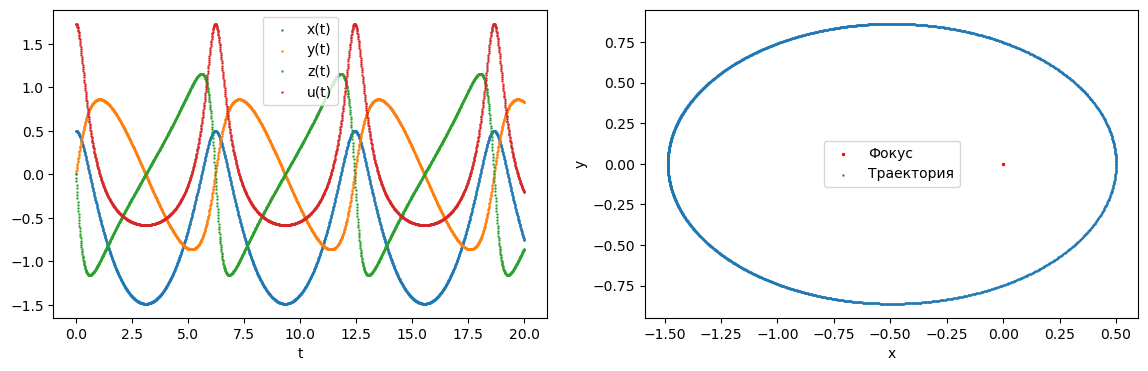

In [167]:
A = np.array([
    [  0,   0,   0, 0],
    [1/2,   0,   0, 0],
    [  0, 1/2,   0, 0],
    [  0,   0,   1, 0],
])

b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([  0, 1/2, 1/2,   1])

classic_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(classic_butcher, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

### Метод "правило 3/8" четвертого порядка

<img src="3Above8-RK.png" width=900/>

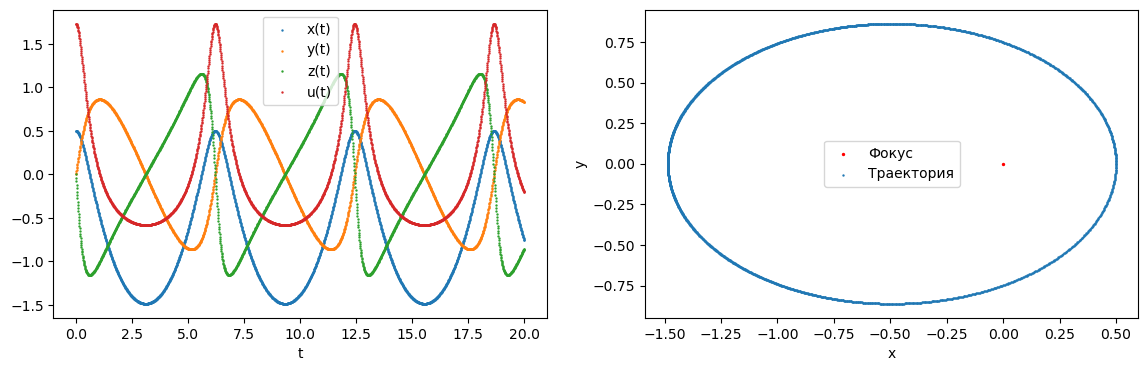

In [168]:
A = np.array([
    [   0,  0,  0, 0],
    [ 1/3,  0,  0, 0],
    [-1/3,  1,  0, 0],
    [   1, -1,  1, 0],
])

b = np.array([1/8, 3/8, 3/8, 1/8])
c = np.array([0,   1/3, 2/3,   1])

three_eight_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(three_eight_butcher, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

##  Методы Адамса

Все коэффициенты брал отсюда. 
https://en.wikipedia.org/wiki/Linear_multistep_method#

Ну и см. фото ниже:

<img src="Adams.png" width=900/>

In [169]:
#
# Не такой великий решатель ОДУ методом Адамса.
#
def Adams_Solve(adams_coeffs, fn, t_0, x_0, h_step, n_iters, butcher_tab = classic_butcher): 
    
    #
    # Начальные итерации проведем методом Рунге-Кутта.
    #
    __steps = len(adams_coeffs)
    __t_points, __x_points = RK_Solve(butcher_tab, fn, t_0, x_0, h_step, __steps - 1)

    __x_points = list( __x_points)
    __t_points = list( __t_points)
    
    for __i in range(n_iters): 
        __x_accum = np.zeros(x_0.shape)
        for __j in range(__steps):
            __x_accum = __x_accum + adams_coeffs[-__j - 1] * fn( __t_points[__j - __steps], __x_points[__j - __steps])

        __x_points.append(__x_points[-1] + h_step * __x_accum)
        __t_points.append(__t_points[-1] + h_step)

    return np.array(__t_points), np.array(__x_points)


### Метод Адамса первого порядка (он же метод Эйлера. Опять...)

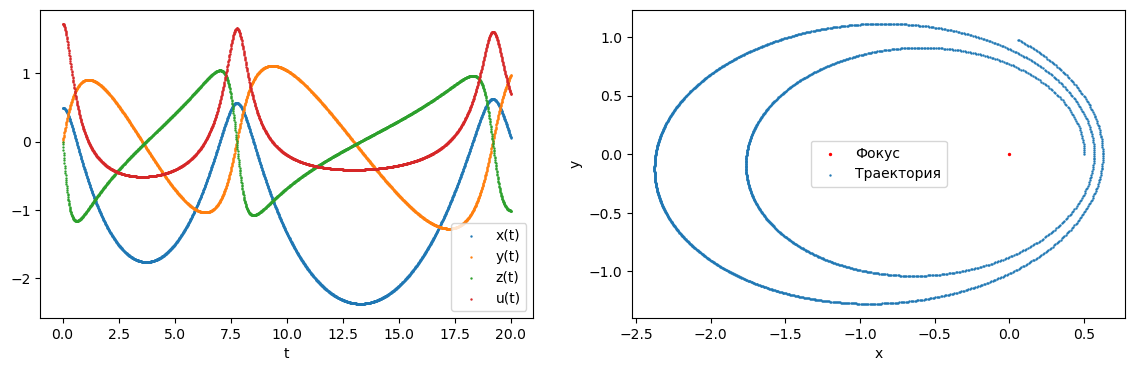

In [170]:
adams_table = np.array([1])
t_points, points = Adams_Solve(adams_table, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

### Метод Адамса четвертого порядка

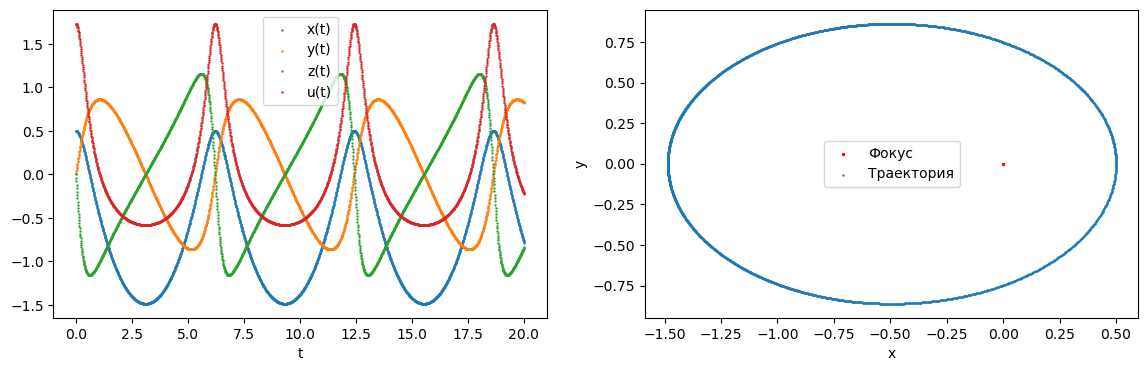

In [171]:
adams_table = np.array([+55/24, -59/24, +37/24, -9/24])
t_points, points = Adams_Solve(adams_table, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

##  Методы ФДН

Все коэффициенты брал отсюда:

https://en.wikipedia.org/w/index.php?title=Backward_differentiation_formula&oldid=1166087118

Ну и см. фото ниже:

<img src="BFD-General.png" width=650/>

<img src="BFD.png" width=900/>

In [172]:
#
# Уравнение ФДН для определения x_n+1.
# (см. https://en.wikipedia.org/w/index.php?title=Backward_differentiation_formula&oldid=1166087118)
# x_n+s + c[0] * x_n+s-1 + c[1] * x_n+s-2 + ... + c[s] * x_n = beta * h * f(t_n+s, x_n+s)
#
class BDF_System:
    def __init__(self, alphas, beta, fn, t_n, x_series, h_step):

        self.fn = fn
        self.alpha = alphas[-1]
        self.beta  = beta * h_step
        self.t_s = t_n + h_step
          
        # Предварительно просчитаем коэффициенты:      
        self.precomputed = np.zeros(x_series[0].shape)
        for __i in range(len(alphas) - 1):
            self.precomputed += alphas[__i] * x_series[__i]

    def __call__(self, x):
        return self.alpha * x + self.precomputed - self.beta * self.fn(self.t_s, x)

#
# Совсем не такой великий решатель ОДУ методом ФДН.
#
def BDF_Solve(alphas, beta, fn, t_0, x_0, h_step, n_iters, butcher_tab = classic_butcher): 
    
    #
    # Начальные итерации проведем методом Рунге-Кутта.
    #
    __steps = len(alphas) - 1
    __t_points, __x_points = RK_Solve(butcher_tab, fn, t_0, x_0, h_step, __steps - 1)

    __x_points = list( __x_points)
    __t_points = list( __t_points)
    
    for __i in range(n_iters):
        __bfd_system = BDF_System(alphas, beta, fn, __t_points[-1], __x_points[-__steps:], h_step)
        __x_points.append( op.fsolve(__bfd_system, __x_points[-1]))
        __t_points.append(__t_points[-1] + h_step)

    return np.array(__t_points), np.array(__x_points)

### ФДН пятого порядка

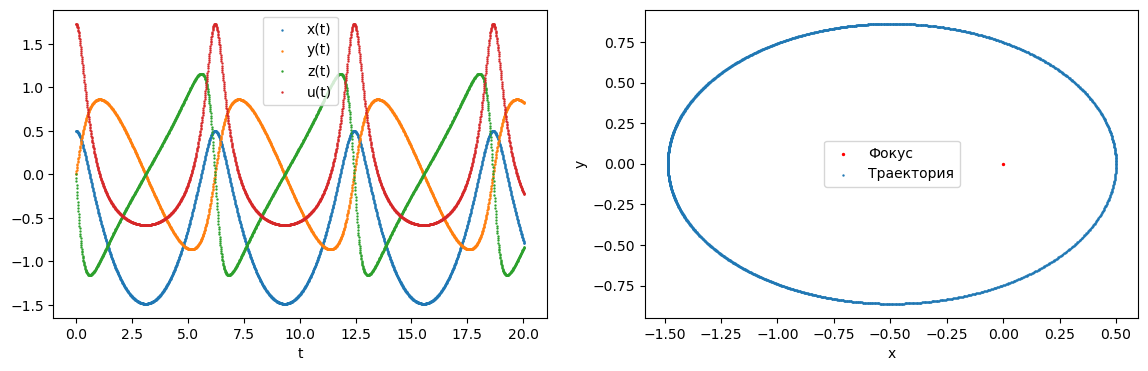

In [173]:
bfd_coeffs = np.array([-12/137, 75/137, -200/137, 300/137, -300/137, 1])
bfd_beta = 60/137
t_points, points = BDF_Solve(bfd_coeffs, bfd_beta, Input.fn, Input.t_0, Input.x_0, h_step = 0.01, n_iters = 2000)
Input.visualize(t_points, points)

# X.9.11.

<img src="X.9.11.png" width=900/>

In [208]:
def F(t : float, x : np.array) -> np.array:
    __y1, __y2, __y3, __y4, __y5, __y6, __y7, __y8 = x
    return np.array([
        -1.71 * __y1 + 0.43 * __y2 + 8.23 * __y3 + 0.0007,
         1.71 * __y1 - 8.75 * __y2,
        -10.03 * __y3 + 0.43 * __y4 + 0.035 * __y5,
        8.32 * __y2 + 1.71 * __y3 - 1.12 * __y4,
        -1.745 * __y5 + 0.43 * __y6 + 0.43 * __y7,
        -280 * __y6 * __y8 + 0.69 * __y4 + 1.71 * __y5 - 0.43 * __y6 + 0.69 * __y7,
        280 * __y6 * __y8 - 1.87 * __y7,
        -(280 * __y6 * __y8 - 1.87 * __y7),
    ])

#
# Входные данные: начальные условия, система и др. 
# (используется во всех методах задания X.9.11).
#
class InputX:
    fn = F
    x_0 = np.array([1, 0, 0, 0, 0, 0, 0, 0.0057])
    t_0 = 0
    T_k = 421.8122
    
    #
    # Визуализация решения.
    #
    def visualize(ts, xs):
        __y1, __y2, __y3, __y4, __y5, __y6, __y7, __y8 = points.transpose()
        fig, timed = plt.subplots(1, 1, figsize=(14, 4))
        size = 0.2
        
        timed.scatter(t_points, __y1, label='y_1(t)', s=size)
        timed.scatter(t_points, __y2, label='y_2(t)', s=size)
        timed.scatter(t_points, __y3, label='y_3(t)', s=size)
        timed.scatter(t_points, __y4, label='y_4(t)', s=size)
        timed.scatter(t_points, __y5, label='y_5(t)', s=size)
        timed.scatter(t_points, __y6, label='y_6(t)', s=size)
        timed.scatter(t_points, __y7, label='y_7(t)', s=size)
        timed.scatter(t_points, __y8, label='y_8(t)', s=size)
        timed.set_xlabel('t')
        timed.legend()


## Метод Эйлера

Метод Эйлера умеет удивлять! Можно наблюдать расщепление концентраций веществ! Красиво!!!

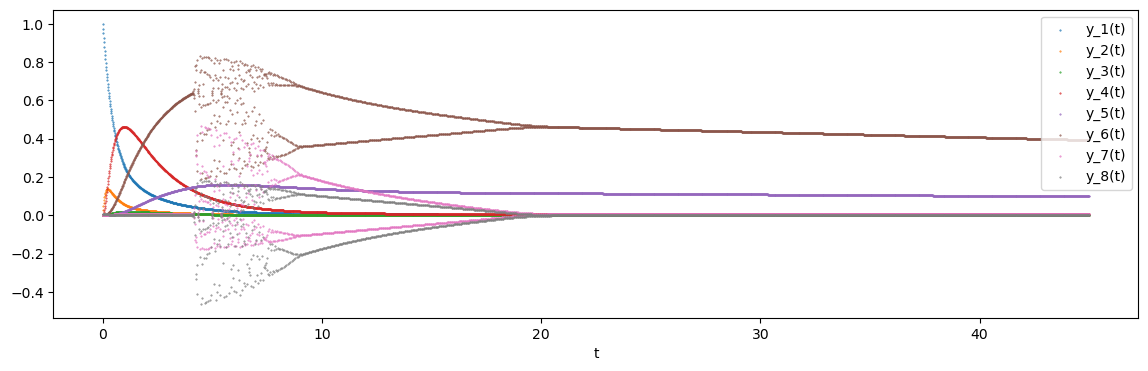

In [209]:
A = np.array([
    [0],
])

b = np.array([1])
c = np.array([0])

euler_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(euler_butcher, InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.015, n_iters = 3000)
InputX.visualize(t_points, points)

## Неявный метод Рунге-Кутты

<img src="RK-Implicit.png" width=900/>

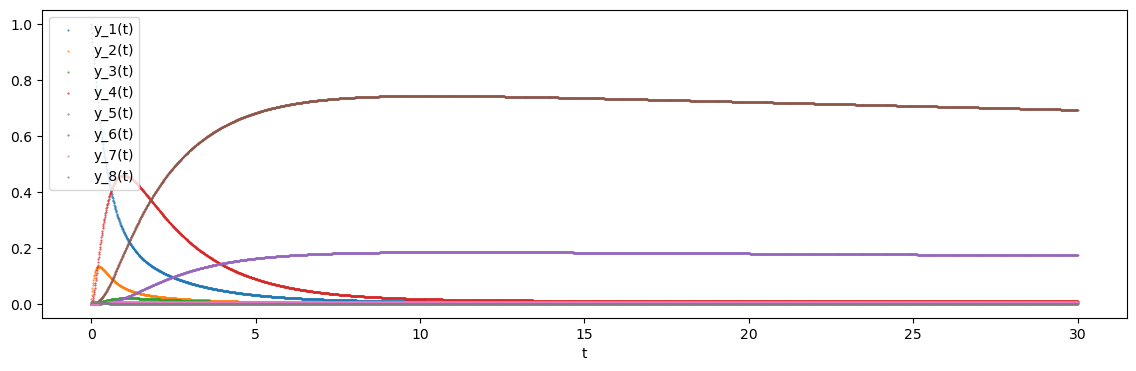

In [210]:
A = np.array([
    [  1/2,   0,     0,   0],
    [  1/6,   1/2,   0,   0],
    [ -1/2,   1/2, 1/2,   0],
    [  3/2,  -3/2, 1/2, 1/2],
])

b = np.array([3/2, -3/2, 1/2, 1/2])
c = np.array([1/2,  2/3, 1/2,   1])

implicit_butcher = Butcher(A, b, c)
t_points, points = RK_Solve(implicit_butcher, InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.01, n_iters = 3000)
InputX.visualize(t_points, points)

## Методы Розенброка (Розенброка-Ванера)

Источник (спасибо Александру за ссылку): Al’shin, A.B., Al’shina, E.A., Kalitkin, N.N. et al. Rosenbrock schemes with complex coefficients for stiff and differential algebraic systems.

Записи с семинара также помогли...

<img src="CROS-1.png" width=900/>
<img src="CROS-2.png" width=900/>

In [258]:
#
# Считаем Якобиан, используя навыки прошлого семестра!
#
def Jacobian(f, x, h):
    __n = len(f(x))
    __J = np.zeros((__n, __n))
    for __i in range(__n):
        for __j in range(__n):
            __step = np.zeros(__n)
            __step[__j] = h
            __J[__i][__j] = (f(x + __step) - f(x - __step))[__i] / (2 * h)

    return __J

#
# Решатель ОДУ CROS методом.
#  
def Rosenbrock_Solve(fn, t_0, x_0, h_step, n_iters): 

    __x_points = [x_0]
    __t_points = [t_0]

    __t_n = t_0
    __x_n = x_0

    for __i in range(n_iters):
        
        #
        # Решаем линейную систему уравнений Aw = f на каждой итерации
        # (см. семинар. Хотя я не знаю, как вы посмотрите семинар...)
        #
        __jacobi = Jacobian(lambda x: InputX.fn(0, x), InputX.x_0, 1e-6)
        __A = np.eye(len(x_0)) -  h_step * __jacobi * (1 + 1j) / 2
        __f = fn( __t_n + h_step, __x_n)
        __w = np.linalg.solve(__A, __f)
        
        __x_n = __x_n + h_step * np.real(__w)
        __t_n = __t_n + h_step

        __x_points.append(__x_n)
        __t_points.append(__t_n)

    return np.array(__t_points), np.array(__x_points)

Тут, если поиграть с шагом, расщепления пропадают. Оставлю два варианта...

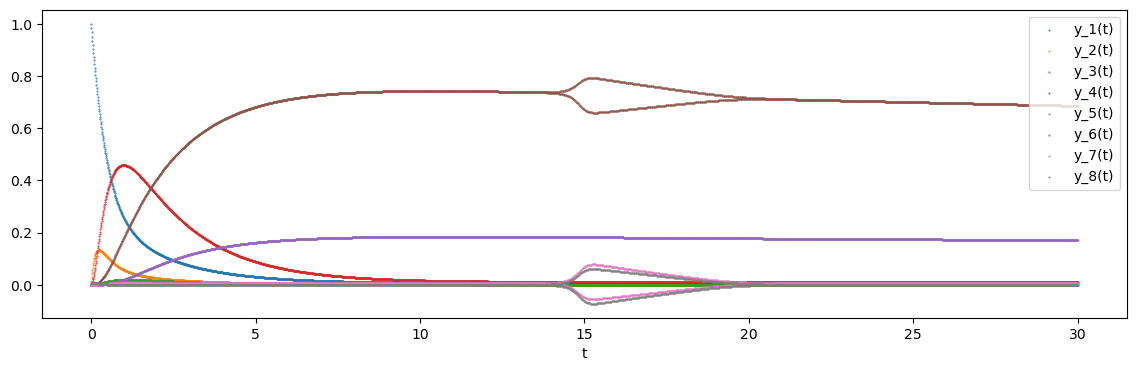

In [259]:
t_points, points = Rosenbrock_Solve(InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.01, n_iters = 3000)
InputX.visualize(t_points, points)

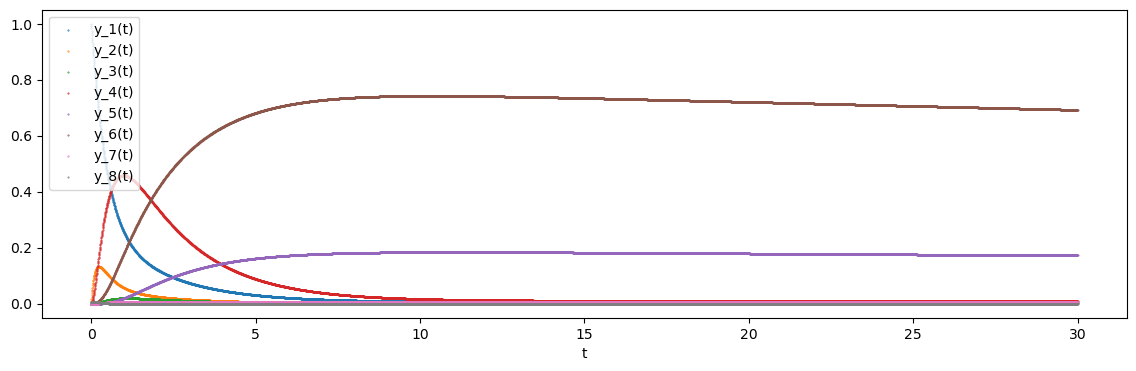

In [257]:
t_points, points = Rosenbrock_Solve(InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.005, n_iters = 6000)
InputX.visualize(t_points, points)

## Неявные методы Адамса/ФДН (методы Гира) в представлении Нордсика

<img src="Nordsik.png" width=900/>

<img src="Nordsik-Tables.png" width=900/>

In [292]:
import scipy.linalg

#
# Решатель ОДУ в представлении Нордсика.
#  
def Nordsik_Solve(l, fn, t_0, x_0, h_step, n_iters): 
    
    __x_points = [x_0]
    __t_points = [t_0]

    __t_n = t_0
    __x_n = x_0

    __k = len(l)
    __P = scipy.linalg.pascal(__k, kind='upper')
    __l = np.array(l)
    __e1 = np.zeros(__k)
    __e1[1] = 1.0

    #
    # Для старта можно положить z = (x_0, 0, ..., 0)
    # (см. задачник)
    #
    __z = np.zeros((__k, len(x_0)))
    __z[0] = x_0
    
    for __i in range(n_iters):

        __z = np.matmul(__P, __z) \
              + np.outer(__l, h_step * fn(__t_n, __x_n) - np.dot(__e1, np.matmul(__P, __z)))
        
        __x_n = __z[0]
        __t_n = __t_n + h_step

        __x_points.append(__x_n)
        __t_points.append(__t_n)

    return np.array(__t_points), np.array(__x_points)


### Неявный метод Адамса представлении Нордсика

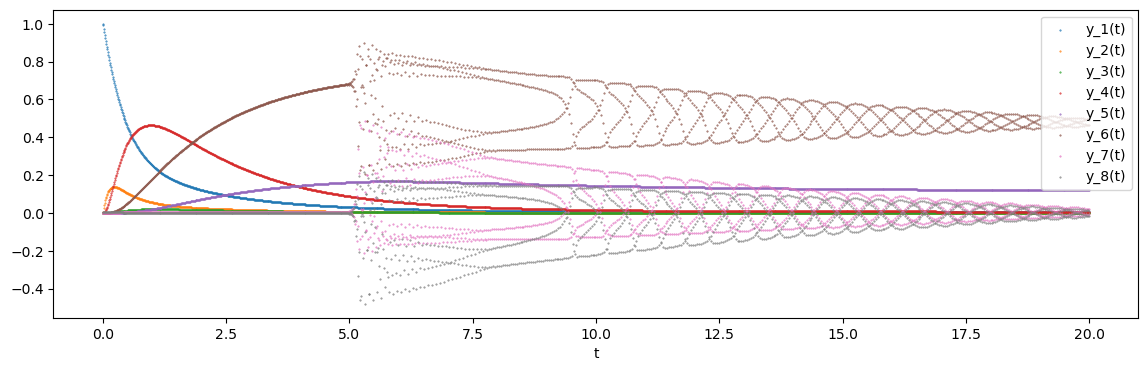

In [291]:
l = np.array([251/720, 1, 11/12, 1/3, 1/24])
t_points, points = Nordsik_Solve(l, InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.01, n_iters = 2000)
InputX.visualize(t_points, points)

Уменьшим шаг:

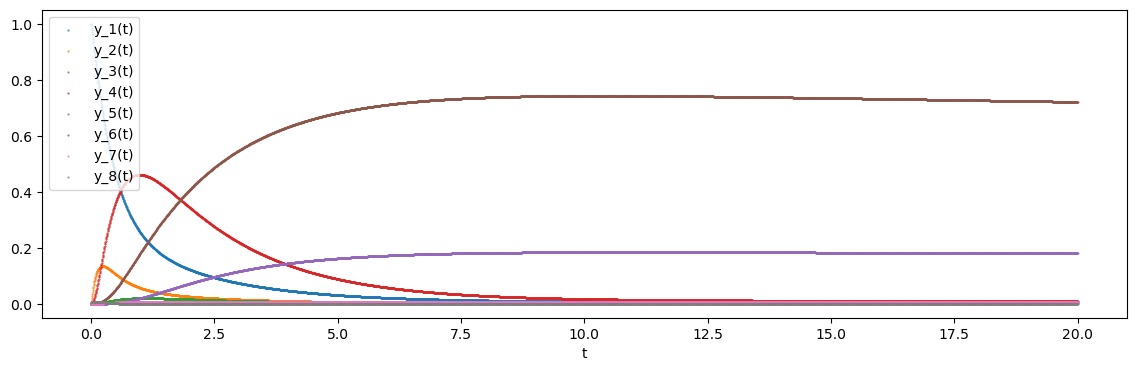

In [289]:
l = np.array([251/720, 1, 11/12, 1/3, 1/24])
t_points, points = Nordsik_Solve(l, InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.005, n_iters = 4000)
InputX.visualize(t_points, points)

### ФДН в представлении Нордсика

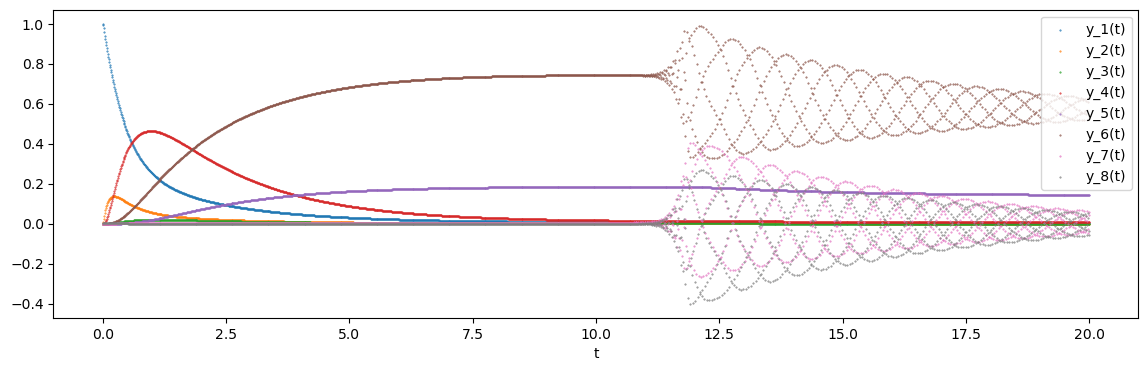

In [288]:
l = np.array([12/25, 1, 7/10, 1/5, 1/50])
t_points, points = Nordsik_Solve(l, InputX.fn, InputX.t_0, InputX.x_0, h_step = 0.01, n_iters = 2000)
InputX.visualize(t_points, points)